<a href="https://colab.research.google.com/github/AlmahdiPen/Visi_Komputer_TI-2A/blob/main/Teknik_Regresi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

##1) Setup & Generator Dataset

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    """Menghasilkan citra lingkaran putih di latar hitam dan label radiusnya."""
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

##2) “Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label


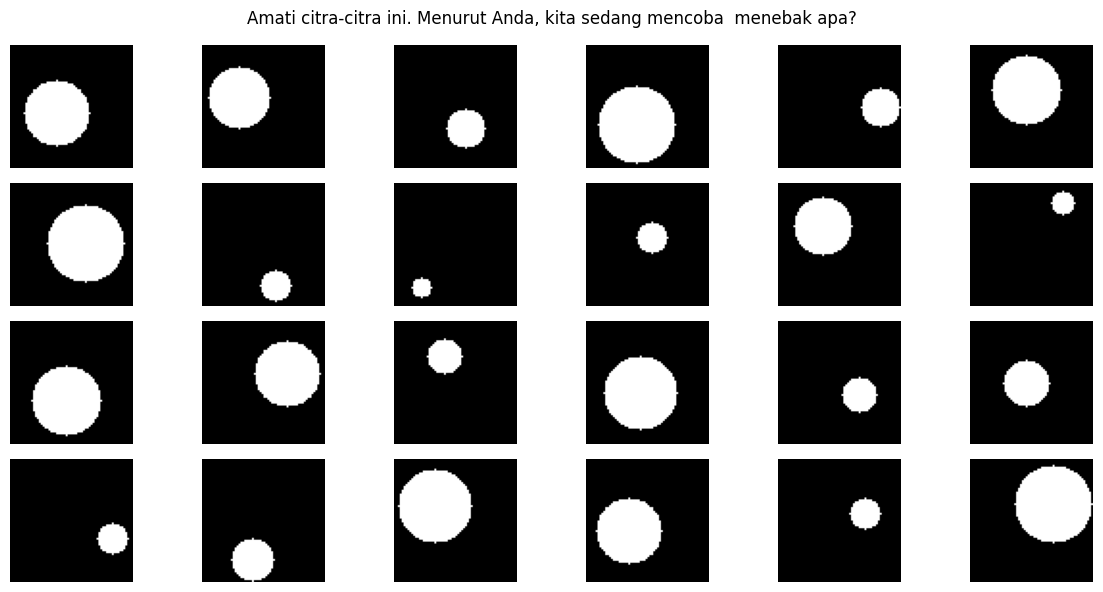

In [74]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    # squeeze() untuk menghapus channel dimension jika citra grayscale 1-channel
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba  menebak apa?")
plt.tight_layout()
plt.show()

##3) Buka Jawaban — Target yang Ingin Diprediksi

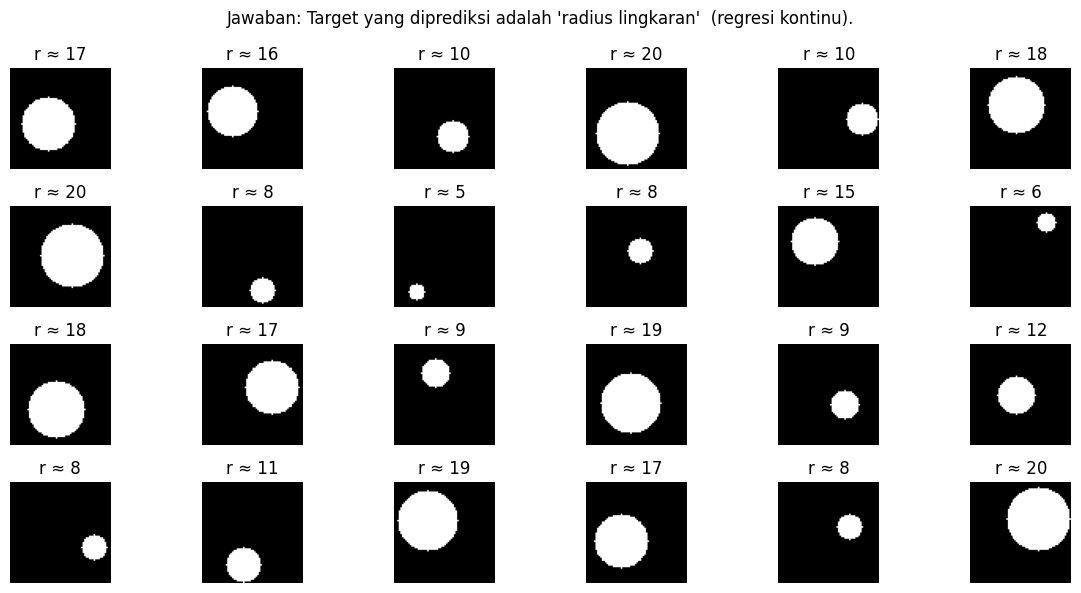

In [75]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran'  (regresi kontinu).")
plt.tight_layout()
plt.show()

##4) (Opsional) Latih CNN Kecil untuk Memprediksi Radius

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.968 | RMSE=1.202 | R²=0.930


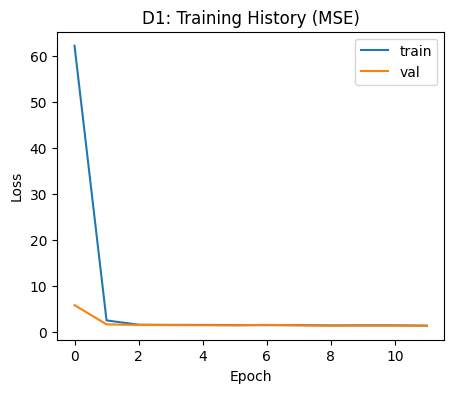

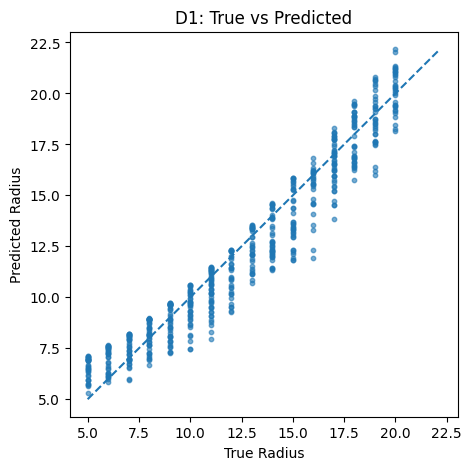

In [76]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# Plot history & True vs Predicted:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

#Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)

##Langkah 1 & 2 — Mengunggah kaggle.json ke Colab

In [77]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"muhammadalmahditi","key":"a2410149dd19e912ac8af9cf9b0c0f1c"}'}

In [78]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  print("✅ Kaggle API siap digunakan.")
else:
  print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [79]:
!pip -q install kaggle

##Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle

In [80]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKface berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
✅ Dataset UTKface berhasil diekstrak.


##Langkah 4 — Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


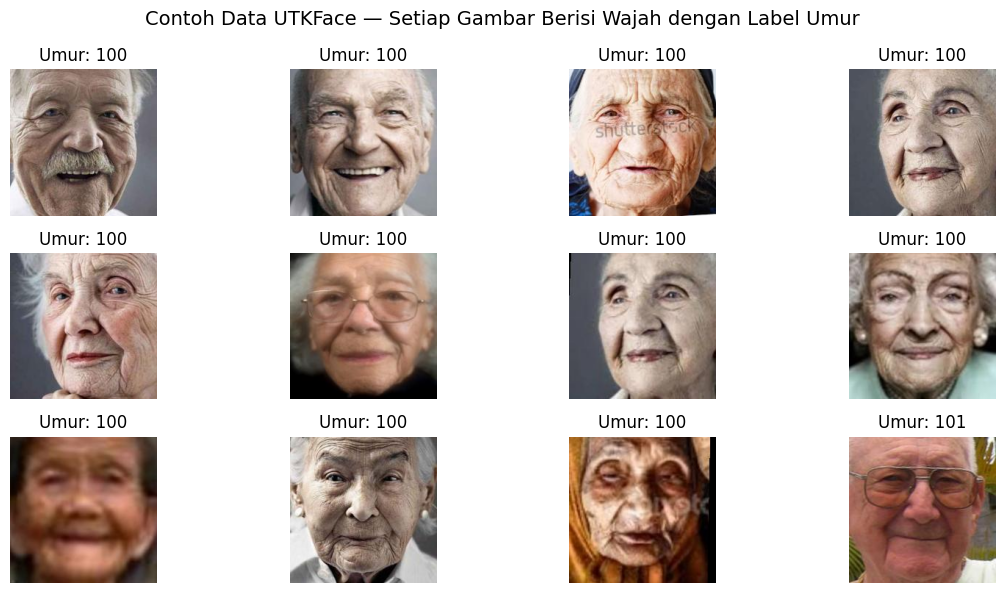

In [81]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

##Langkah 5 — Siapkan Dataset untuk Model

In [82]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    """Mengekstrak label umur dari nama file"""
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    """Fungsi untuk memuat, mengubah ukuran, dan menormalisasi gambar"""
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print(" ✅ Dataset siap dilatih.")

 ✅ Dataset siap dilatih.


##Langkah 6 — Membangun Model dengan Transfer Learning

In [83]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else  "CPU")

# Model dasar MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Preprocessing untuk MobileNetV2 harus dilakukan pada input (0-255)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_3 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 105ms/step - loss: 355.4886 - mae: 13.8480 - val_loss: 161.6889 - val_mae: 9.7057 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 155.9166 - mae: 9.3061 - val_loss: 146.6686 - val_mae: 9.0739 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 144.4512 - mae: 8.8800 - val_loss: 146.7159 - val_mae: 9.1336 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 139.8675 - mae: 8.7244 - val_loss: 140.0731 - val_mae: 8.8100 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 138.1624 - mae: 8.6400 - val_loss: 139.7531 - val_mae: 8.7864 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 135.4120 - mae: 8.5347 - val_loss: 137.6773 - val_mae: 8.7012 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 135.1322 - mae: 8.4793 - val_loss: 135.3628 - va

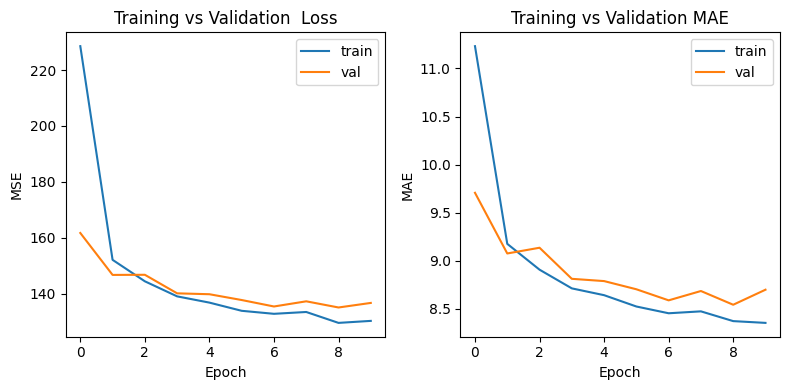

In [84]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
    monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation  Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

##Langkah 8 — Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - loss: 188.9659 - mae: 10.0977 - val_loss: 152.1921 - val_mae: 9.2473 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 77.4662 - mae: 6.5335 - val_loss: 170.1840 - val_mae: 10.0756 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 52.7242 - mae: 5.4165 - val_loss: 134.3840 - val_mae: 8.7368 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 37.8861 - mae: 4.6316 - val_loss: 106.4499 - val_mae: 7.4466 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 29.3005 - mae: 4.0865 - val_loss: 123.3905 - val_mae: 8.3659 - learning_rate: 1.0000e-04


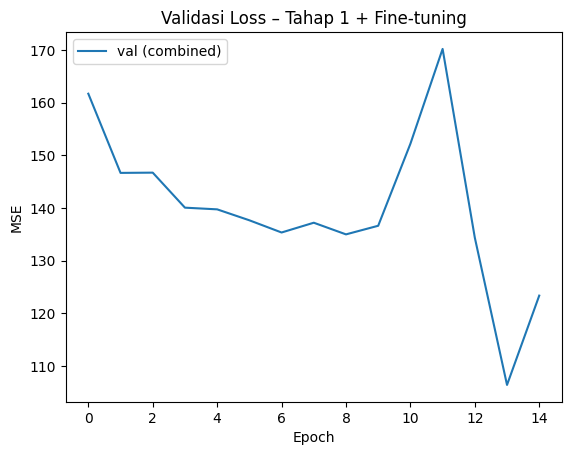

In [85]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
    label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

##Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.45 tahun
RMSE = 10.32 tahun
R² = 0.732


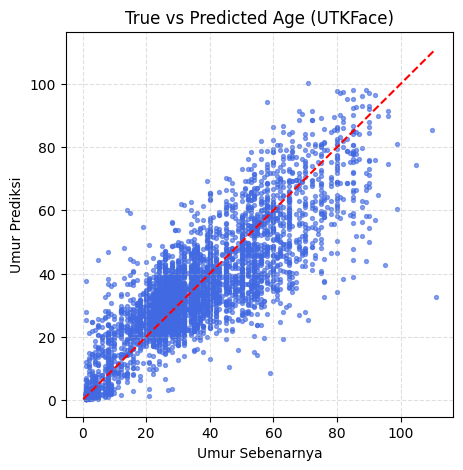

In [86]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Prediksi pada test data
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

# Hitung metrik
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

##Langkah 10 — Melihat Contoh Prediksi Nyata

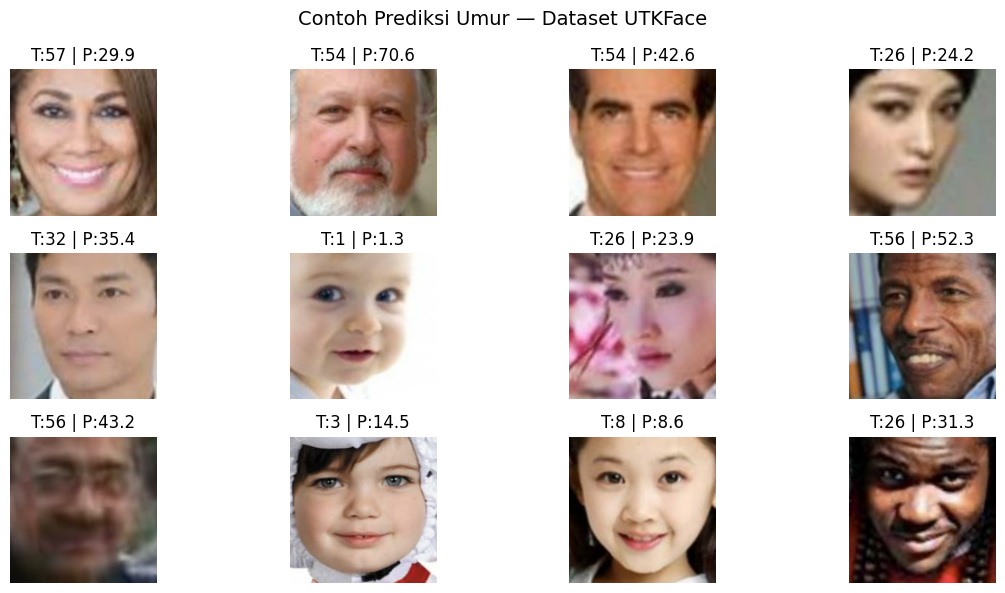

In [87]:
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Ambil 12 sampel acak dari test data
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    # Memuat dan pre-processing citra
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0

    true_age = int(os.path.basename(path).split('_')[0])

    # Prediksi umur
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

#Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto

##Langkah 1 & 2 — Menyiapkan Kaggle API dan Mengunduh Dataset

In [88]:
# Langkah 1: Setup Kaggle API (Sama dengan D2)
from google.colab import files
# files.upload() # pilih kaggle.json dari komputer Anda (Jalankan di Colab)

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print(" ✅  Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

 ✅  Kaggle API siap digunakan.


In [89]:
# Langkah 2: Unduh dan Ekstrak Dataset (Pastikan sudah 'Join Competition' di Kaggle)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print(" ✅  Dataset Pawpularity berhasil diekstrak.")

replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 ✅  Dataset Pawpularity berhasil diekstrak.


##Langkah 3 — Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

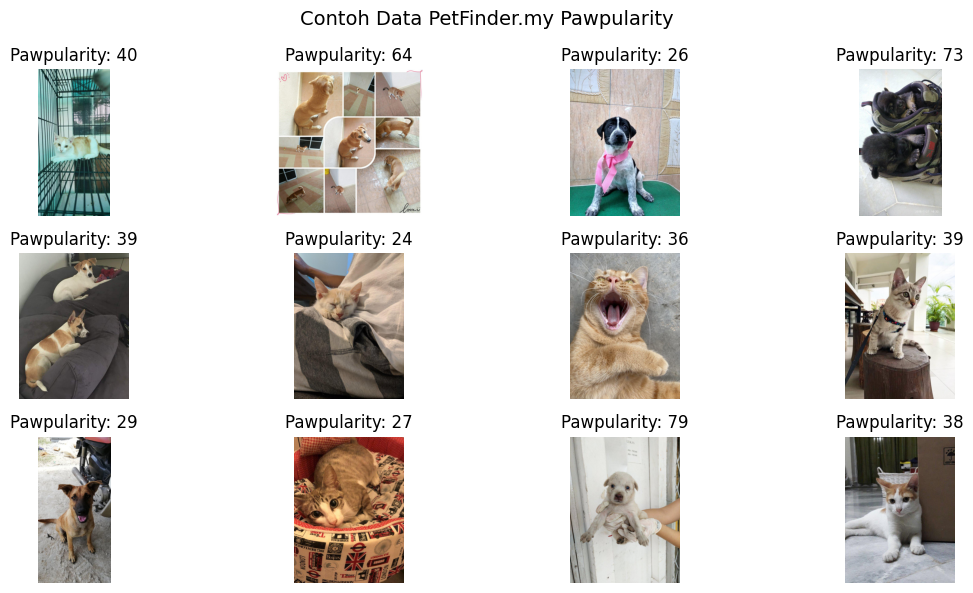

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

##Langkah 4 — Persiapan Dataset

In [91]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    """Memuat, decode, resize, dan normalisasi citra untuk EfficientNet."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Buat TensorFlow Dataset dengan batching dan prefetching
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
    train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
    val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training,  {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training,  1983 untuk validasi.


##Langkah 4 — Membangun Model (EfficientNetB0)

In [92]:
from tensorflow.keras import layers, models

# Model dasar EfficientNetB0
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

# Tambahkan head regresi
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
# Preprocessing khusus EfficientNet
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: Pawpularity score
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_4 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

##Langkah 5 — Melatih Model

In [93]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3,
    restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,
    callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 90s 389ms/step - loss: 840.7585 - mae: 22.0229 - val_loss: 484.1446 - val_mae: 16.0944 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 54s 243ms/step - loss: 430.8230 - mae: 15.2151 - val_loss: 430.7871 - val_mae: 15.2158 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - loss: 394.2094 - mae: 14.7647 - val_loss: 404.3277 - val_mae: 14.7683 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - loss: 360.9601 - mae: 14.1278 - val_loss: 389.5139 - val_mae: 14.5580 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - loss: 357.5236 - mae: 13.9960 - val_loss: 380.3234 - val_mae: 14.4205 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 267ms/step - loss: 359.0943 - mae: 14.1189 - val_loss: 375.7234 - val_mae: 14.2810 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - loss: 334.1034 - mae: 13.6493 - val_l

##Langkah 6 — Melihat Proses Belajar

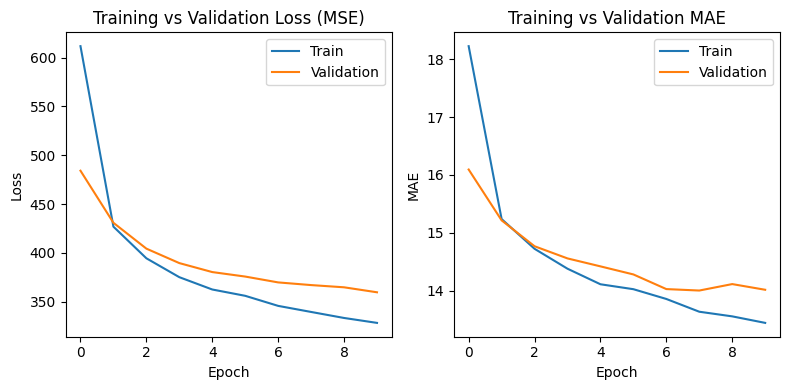

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()

plt.tight_layout()
plt.show()

##Langkah 7 — Evaluasi Model

MAE = 14.02
RMSE = 18.96
R² = 0.186


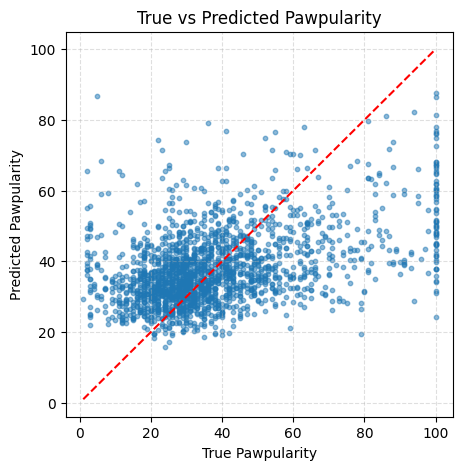

In [95]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# Prediksi pada validation data
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for  batch in val_ds])

# Hitung metrik
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

##Langkah 8 — Melihat Contoh Prediksi

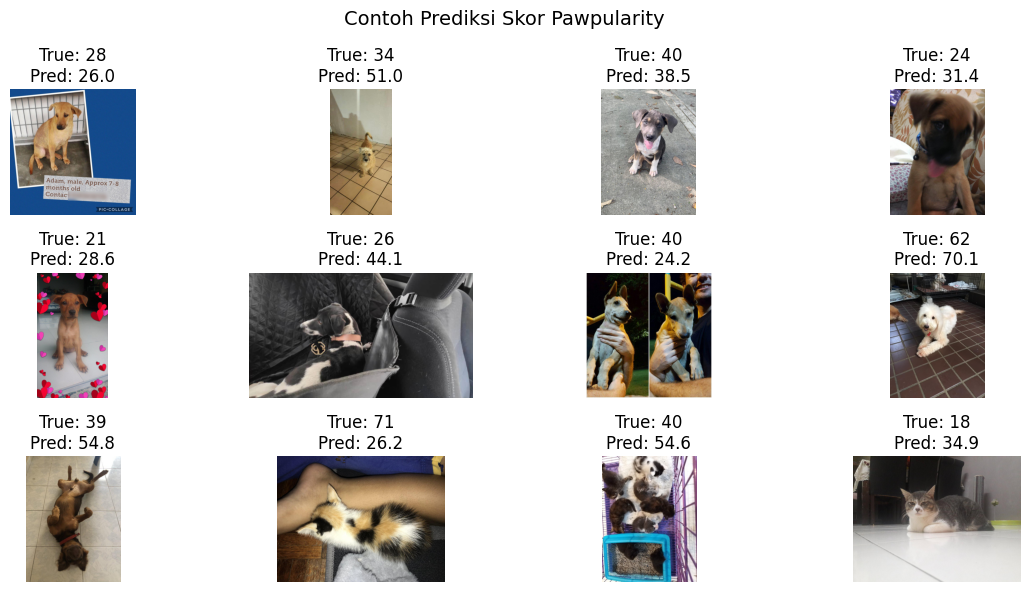

In [96]:
import random
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Ambil 12 sampel acak dari validation data
sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    # Memuat dan pre-processing citra
    img_tensor, _ = load_image(row.path, row.Pawpularity)

    # Prediksi skor
    pred = model.predict(tf.expand_dims(img_tensor, 0), verbose=0).ravel()[0]

    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

#Penugasan

##1. Uji Coba Prediksi Usia (Model D2: UTKFace)

In [97]:
import tensorflow as tf
from PIL import Image
import numpy as np

# 1. Unggah Foto Pribadi
# Jalankan ini, lalu pilih file foto wajah Anda (.jpg atau .png) dari komputer
from google.colab import files
uploaded = files.upload()

# Asumsikan nama file foto Anda adalah 'my_face.jpg' (Ganti jika berbeda)
my_photo_path = list(uploaded.keys())[0]
IMG_SIZE = 160  # Ukuran yang digunakan saat training model D2 [cite: 275]

# 2. Fungsi Pre-processing (Sama dengan load_img di D2)
def preprocess_my_image(img_path):
    # Membaca dan decode file
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    # Resize ke ukuran training
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # Normalisasi (0-1)
    img = img / 255.0
    # Mengubah ke numpy array dan menambah dimensi batch
    return tf.expand_dims(img, 0)

# Load dan preprocess
my_input_tensor = preprocess_my_image(my_photo_path)

Saving Cuplikan layar 2025-10-16 205949.png to Cuplikan layar 2025-10-16 205949.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


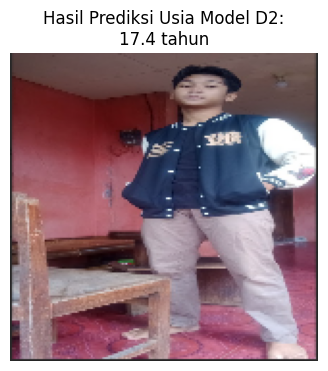

Foto: Cuplikan layar 2025-10-16 205949.png
Umur Prediksi Model: 17.4 tahun


In [98]:
# Pastikan model D2 (MobileNetV2) sudah selesai dilatih dan bernama 'model'
# Jika Anda menjalankan D3 setelah D2, Anda perlu memuat ulang model D2 atau pastikan namanya unik.

# 1. Prediksi Umur
predicted_age_tensor = model.predict(my_input_tensor)
predicted_age = predicted_age_tensor.ravel()[0]

# 2. Tampilkan Hasil
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
# Tampilkan citra asli (tanpa normalisasi 0-255)
plt.imshow(my_input_tensor[0].numpy())
plt.title(f"Hasil Prediksi Usia Model D2:\n{predicted_age:.1f} tahun")
plt.axis('off')
plt.show()

# Teks yang akan Anda masukkan ke Laporan:
print(f"Foto: {my_photo_path}")
print(f"Umur Prediksi Model: {predicted_age:.1f} tahun")

#2. Uji Coba Pawpularity (Model D3: EfficientNetB0)

In [99]:
# 1. Unggah Foto Hewan Peliharaan
# Jalankan ini, lalu pilih file foto hewan peliharaan Anda (.jpg atau .png)
from google.colab import files
uploaded_pet = files.upload()

# Asumsikan nama file foto hewan Anda
pet_photo_path = list(uploaded_pet.keys())[0]
IMG_SIZE_PET = 224 # Ukuran yang digunakan saat training model D3 [cite: 501]

# 2. Fungsi Pre-processing (Menggunakan preprocess_input EfficientNet)
def preprocess_pet_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE_PET, IMG_SIZE_PET))
    img = tf.cast(img, tf.float32)

    # Perlu normalisasi untuk EfficientNet: (inputs * 255.0) -> preprocess_input
    # Di model D3, normalisasi 0-1 dilakukan sebelum base model
    img_normalized_0_1 = img / 255.0

    # Mengubah ke numpy array dan menambah dimensi batch
    return tf.expand_dims(img_normalized_0_1, 0)

# Load dan preprocess
pet_input_tensor = preprocess_pet_image(pet_photo_path)

Saving hewan.jpg to hewan.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


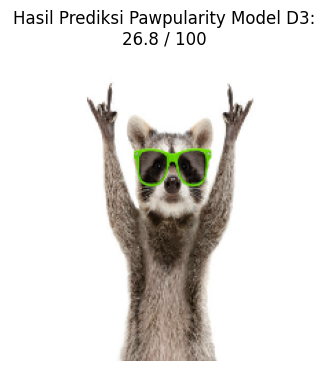

Foto: hewan.jpg
Skor Pawpularity Prediksi Model: 26.8 / 100


In [100]:
# Pastikan model D3 (EfficientNetB0) sudah selesai dilatih dan bernama 'model'
# Catatan: Jika Anda menjalankan ini setelah kode D2, Anda harus memuat ulang model D3

# 1. Prediksi Pawpularity
predicted_pawpularity_tensor = model.predict(pet_input_tensor)
predicted_pawpularity = predicted_pawpularity_tensor.ravel()[0]

# 2. Tampilkan Hasil
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
# Tampilkan citra asli (tanpa normalisasi 0-255)
plt.imshow(pet_input_tensor[0].numpy())
plt.title(f"Hasil Prediksi Pawpularity Model D3:\n{predicted_pawpularity:.1f} / 100")
plt.axis('off')
plt.show()

# Teks yang akan Anda masukkan ke Laporan:
print(f"Foto: {pet_photo_path}")
print(f"Skor Pawpularity Prediksi Model: {predicted_pawpularity:.1f} / 100")

#